# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import cm as c

from utils.val import *
from engine.train import *

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

/Users/seungmi/anaconda3/envs/pyDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/seungmi/anaconda3/envs/pyDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/seungmi/anaconda3/envs/pyDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/seungmi/anaconda3/envs/pyDL/lib/python3

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


tf.compat.v1.enable_eager_execution() 

# Define functions

In [3]:
def ConvMax(filters, size, max_pooling = False, apply_batchnorm=False):
    '''
    objective: create a model with Conv2D, Relu and Maxpool2D layers
    param: filters - int 
           size - int for kernel size
           max_pooing - boolean for whether to include maxpool layer or not
    '''
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(
        keras.layers.Conv2D(filters, size, padding='same' ,kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(keras.layers.ReLU())
    if max_pooling:
        result.add(keras.layers.MaxPool2D())

    return result

In [4]:
def MCNN():
    '''
    objective: create MCNN with three parelleled CNNs
    '''
    inputs = tf.keras.layers.Input(shape=[None,None,3])

    mod1 = [
    ConvMax(16, 9, max_pooling = True, apply_batchnorm=False),
    ConvMax(32, 7, max_pooling = True),
    ConvMax(16, 7, max_pooling = True),
    ConvMax(8, 7),
    ]

    mod2 = [
    ConvMax(20, 7, max_pooling = True, apply_batchnorm=False),
    ConvMax(40, 5, max_pooling = True),
    ConvMax(20, 5, max_pooling = True),
    ConvMax(10, 5),
    ]
    
    mod3 = [
    ConvMax(24, 5, max_pooling = True, apply_batchnorm=False),
    ConvMax(48, 3, max_pooling = True),
    ConvMax(24, 3, max_pooling = True),
    ConvMax(12, 3),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    x = inputs

    for val1, val2, val3 in zip(mod1, mod2, mod3):
        x1 = val1(x)
        x2 = val2(x)
        x3 = val3(x)
        x = keras.layers.Concatenate()([x1,x2,x3])

    density_map = keras.layers.Conv2D(1, 1, padding='same', activation='linear')

    x = density_map(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [5]:
model = MCNN()

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 1 3888        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, None, None, 2 2940        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, None, None, 2 1800        input_1[0][0]                    
______________________________________________________________________________________________

# Train model

In [7]:
# define part(A or B),epochs and learning rates 
model = fit(model,"A",epochs=1, learning_rate = 0.0002)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Part A Learning started. It takes sometime.


Loss: 0.0478 44850 / 44850,44850


Epoch: 1 Test MAE =  225.0399
Learning Finished!


# Visualize test outputs

Original Count :  902
Original Density Map


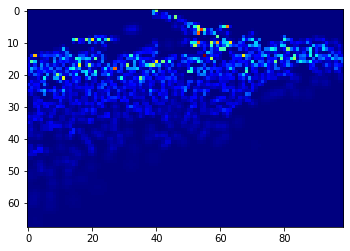

Predicted Count :  3860


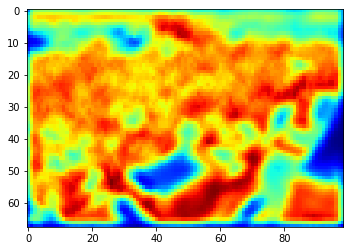

Original Image


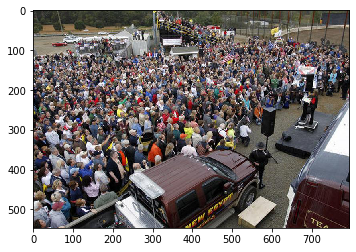

In [8]:
generate_images(model, test_input = 'ShanghaiTech/part_A/test_data/images/IMG_130.jpg')

# Load previous model

In [14]:
model = keras.models.load_model('part_A_best_model.h5')
model.summary()

KeyboardInterrupt: 